In [2]:
%matplotlib ipympl

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

import networkx as nx
import matplotlib.patches as mpatches

In [3]:
history_folder = "server/history/"

In [8]:
history_file = os.path.join(history_folder, "history_00000_20250720_224856.json")
history_file = sorted(glob.glob(os.path.join(history_folder, "history_*.json")))[-1]
history_data = json.load(open(history_file, "r"))
print(history_file)

server/history/history_00273_20250724_033159.json


In [9]:
len(history_data["states"]), len(history_data["actions"])

(562, 561)

In [16]:
def draw_state(ax, history_data, index):

    if index < len(history_data["actions"]):
        action = history_data["actions"][index]
    else:
        action = {"move_made": False, "turn_end": False, "player": None}

    state = history_data["states"][index]
    teams = np.array(state["teams"])
    dice = np.array(state["dice"])
    node_positions = history_data["node_positions"]

    pos = {
        i: np.array(node_pos)
        for i, node_pos in enumerate(node_positions)
    }
    xs, ys = zip(*pos.values())            # list of all x and y after shift
    left_pad  = 7.0                        # blank space on the left
    pad = 3.0                        # default
    ax.set_xlim(min(xs) - left_pad,  max(xs) + pad)
    ax.set_ylim(min(ys) - pad,  max(ys) + pad)

    graph = nx.from_numpy_array(np.array(history_data["adjacency"]))

    # 1) Build unique list and assign colors
    unique_teams = sorted(set(teams))  # preserves order
    cmap = plt.get_cmap("Set3")
    # 8 teams max
    color_map = { i: cmap(i) for i in range(8)}

    # 2) Draw nodes using that mapping
    node_colors = [ color_map[t] for t in teams ]
    # Convert hex colors to RGB triples (0-1 range for matplotlib)
    node_colors = list(map(
        lambda hex_str: tuple(int(hex_str.lstrip('#')[i:i+2], 16)/255 for i in (0, 2, 4)),
        [
            "#b37ffe",  # purple
            "#b3ff01",  # lime green
            "#009302",  # dark green
            "#ff7ffe",  # pink
            "#ff7f01",  # orange
            "#b3fffe",  # light cyan
            "#ffff01",  # yellow
            "#ff5858"   # light red
        ]
    ))
    nx.draw_networkx_nodes(
        graph, pos,
        node_size=500,
        node_color=node_colors,
        edgecolors='black',
        ax=ax
    )

    # 3) Draw edges & labels
    # ----------------------------------------------------------
    # 3a) draw ALL ordinary edges (no arrows, default styling)
    #     keep the special edge OUT of this list
    # ----------------------------------------------------------
    if action["move_made"]:
        special_edge = (action["from"], action["to"])  # <-- pick the edge (u, v)
        dice_in_attack = dice[action["from"]] - 1
    else:
        special_edge = None

    ordinary_edges = [e for e in graph.edges() if e != special_edge]

    nx.draw_networkx_edges(
        graph, pos,
        edgelist=ordinary_edges,
        width=2,
        edge_color="grey",
        ax=ax
    )

    if action["move_made"]:
        # ----------------------------------------------------------
        # 3b) draw THAT ONE edge again, but with a styled ARROW
        # ----------------------------------------------------------
        nx.draw_networkx_edges(
            graph, pos,
            edgelist=[special_edge],
            width=3,
            edge_color="darkblue",
            arrows=True,                 # activate arrowheads
            arrowstyle="-|>",            # filled triangular head
            arrowsize=10,                # head size (points)
            ax=ax
        )

        # ----------------------------------------------------------
        # 3c) add a text label on (or near) that edge
        # ----------------------------------------------------------
        edge_lbl = {special_edge: dice_in_attack}   # label text - number of dice used in attack
        nx.draw_networkx_edge_labels(
            graph, pos,
            edge_labels=edge_lbl,
            font_color="darkblue",
            font_weight="bold",
            font_size=11,
            label_pos=0.35,              # 0 = src node, 1 = dst node
            bbox=dict(facecolor="white", edgecolor="none", pad=0.1),
            ax=ax,
            rotate=False
        )


    # ----------------------------------------------------------
    # 3d) create node labels
    # ----------------------------------------------------------
    label_dict = { i: d for i, d in enumerate(dice) }
    nx.draw_networkx_labels(
        graph, pos,
        labels=label_dict,
        font_size=12,
        font_weight='bold',
        ax=ax
    )

    # 4) Build and add legend
    legend_handles = [
        mpatches.Patch(
            facecolor=color_map[team], label=str(team), 
            edgecolor="black", linewidth=1
        )
        for team in unique_teams
    ]
    ax.legend(
        handles=legend_handles,
        title="Player",
        loc='upper left',      # Position the legend at the upper left
    )

    # 5) Add action description title
    title = f"State #{index} / {len(history_data['states']) - 1}"
    title += f"\nPlayer {action['player']}"

    if action["move_made"]:
        title = title \
            + f" attacked" \
            + f" from node {special_edge[0]} to {special_edge[1]}" \
            + f" with {dice_in_attack} dice"
    if action["turn_end"]:
        title += " ended the turn"

    ax.set_title(title, fontsize=16)

    # 6) Finalize
    ax.axis('off')
    ax.format_coord = lambda x, y: ""      # suppress the live x-, y-readout

ValueError: 'c' argument has 8 elements, which is inconsistent with 'x' and 'y' with size 31.

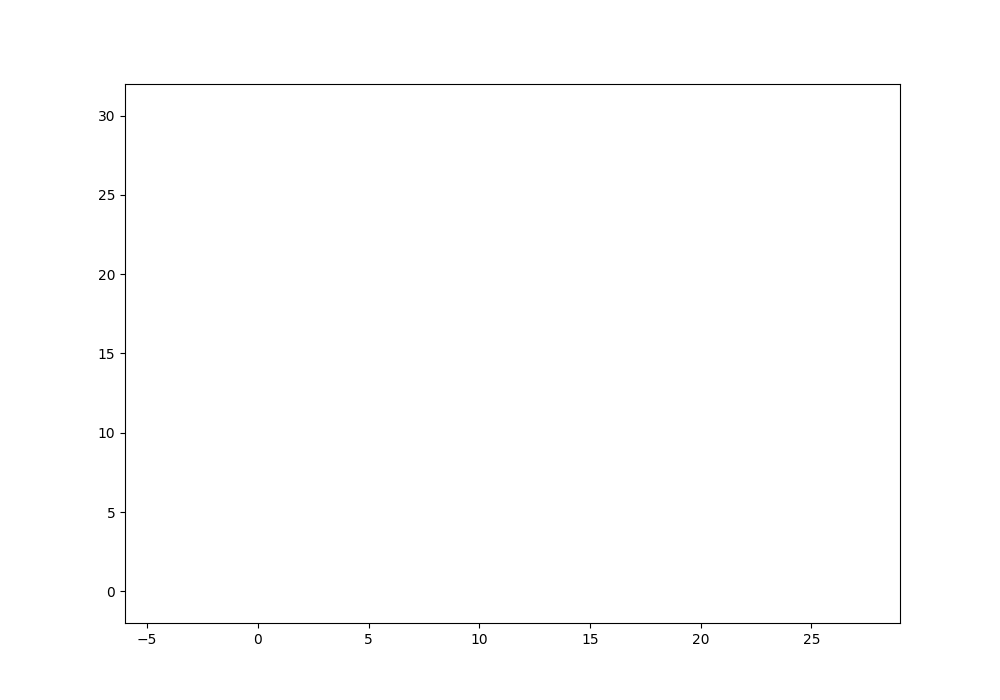

In [17]:
from matplotlib.widgets import Button
from matplotlib.widgets import Button, TextBox

# --- your existing setup ---
f, ax = plt.subplots(1, 1, figsize=(10,7))

n_states = len(history_data["states"])
# Initialize with the first state
current_idx = 0
max_idx = len(history_data["states"]) - 1

# Function to update the plot
def update_plot(idx):
    ax.clear()
    draw_state(ax, history_data, idx)
    plt.draw()

# Initial plot
draw_state(ax, history_data, current_idx)

# Add buttons for navigation and text input
prev_ax = plt.axes([0.25, 0.01, 0.1, 0.05])
next_ax = plt.axes([0.36, 0.01, 0.1, 0.05])  # Centered next button
go_ax = plt.axes([0.59, 0.01, 0.1, 0.05])
text_ax = plt.axes([0.7, 0.01, 0.1, 0.05])


# Create the text input for state index
text_box = TextBox(text_ax, label="", initial=str(current_idx))

# Go button handler
def go_click(event):
    global current_idx
    try:
        idx = int(text_box.text)
        # If the index is out of bounds, clamp it to valid range
        if idx < 0:
            current_idx = 0
        elif idx > max_idx:
            current_idx = max_idx
        else:
            current_idx = idx
    except ValueError:
        current_idx = 0

    text_box.set_val(str(current_idx))
    update_plot(current_idx)

go_button = Button(go_ax, 'Go to')
go_button.on_clicked(go_click)
prev_button = Button(prev_ax, 'Previous')
next_button = Button(next_ax, 'Next')

# Button click handlers
def prev_click(event):
    global current_idx
    current_idx = max(0, current_idx - 1)
    update_plot(current_idx)

def next_click(event):
    global current_idx
    current_idx = min(max_idx, current_idx + 1)
    update_plot(current_idx)

prev_button.on_clicked(prev_click)
next_button.on_clicked(next_click)

plt.show()

In [12]:
plt.close('all')

In [ ]:
plt.close(f)

In [73]:
def get_winner(history_data):
    teams = set(history_data["states"][-1]["teams"])
    if len(teams) != 1:
        raise RuntimeError(f"no single winner: {teams}")
    return teams.pop()

In [74]:
get_winner(history_data)

5

In [ ]:
win_value = 2000
step_value = -1
lose_value = -2000

# the values translate into logic that it's better to lose than to win after win_value - lose_value steps

[{'player': 4, 'from': 5, 'to': 1, 'move_made': True, 'turn_end': False},
 {'player': 4, 'from': 29, 'to': 27, 'move_made': True, 'turn_end': False},
 {'player': 4, 'from': 21, 'to': 20, 'move_made': True, 'turn_end': False},
 {'player': 4, 'from': 13, 'to': 9, 'move_made': True, 'turn_end': False},
 {'player': 4, 'from': 1, 'to': 10, 'move_made': True, 'turn_end': False},
 {'player': 4, 'from': 10, 'to': 23, 'move_made': True, 'turn_end': False},
 {'player': 4, 'from': 27, 'to': 26, 'move_made': True, 'turn_end': False},
 {'player': 4, 'from': 9, 'to': 14, 'move_made': True, 'turn_end': False},
 {'player': 4, 'from': None, 'to': None, 'move_made': False, 'turn_end': True},
 {'player': 5, 'from': 22, 'to': 13, 'move_made': True, 'turn_end': False},
 {'player': 5, 'from': 13, 'to': 7, 'move_made': True, 'turn_end': False},
 {'player': 5, 'from': 6, 'to': 5, 'move_made': True, 'turn_end': False},
 {'player': 5, 'from': 30, 'to': 27, 'move_made': True, 'turn_end': False},
 {'player': 5, '

In [38]:
history_data["actions"]

[{'player': 4, 'from': 4, 'to': 0, 'move_made': True, 'turn_end': False},
 {'player': 4, 'from': 28, 'to': 26, 'move_made': True, 'turn_end': False},
 {'player': 4, 'from': 20, 'to': 19, 'move_made': True, 'turn_end': False},
 {'player': 4, 'from': 12, 'to': 8, 'move_made': True, 'turn_end': False},
 {'player': 4, 'from': 0, 'to': 9, 'move_made': True, 'turn_end': False},
 {'player': 4, 'from': 9, 'to': 22, 'move_made': True, 'turn_end': False},
 {'player': 4, 'from': 26, 'to': 25, 'move_made': True, 'turn_end': False},
 {'player': 4, 'from': 8, 'to': 13, 'move_made': True, 'turn_end': False},
 {'player': 4, 'from': None, 'to': None, 'move_made': False, 'turn_end': True},
 {'player': 5, 'from': 21, 'to': 12, 'move_made': True, 'turn_end': False},
 {'player': 5, 'from': 12, 'to': 6, 'move_made': True, 'turn_end': False},
 {'player': 5, 'from': 5, 'to': 4, 'move_made': True, 'turn_end': False},
 {'player': 5, 'from': 29, 'to': 26, 'move_made': True, 'turn_end': False},
 {'player': 5, 'fr